This notebook gives an example of a multi seasonal AR model in orbit.
There are three parts: Data is simulated, Orbit ARMA and statsmodel ARMA are fit, and results are plotted / compared. 

# Preliminary Test on Orbit ARMA Model

In [1]:
from datetime import datetime, timedelta
import datetime as dt 

import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

import orbit
from orbit.models import ARMA
from orbit.utils.simulation import make_trend, make_regression
from orbit.diagnostics.plot import plot_predicted_data, params_comparison_boxplot

In [2]:
import orbit.constants.palette as palette
from orbit.utils.plot import get_orbit_style
orbit_style = get_orbit_style()
plt.style.use(orbit_style)

In [3]:
%load_ext autoreload
%autoreload 2

## Data Simulation

An AR(1, 24) data is simulated in this block

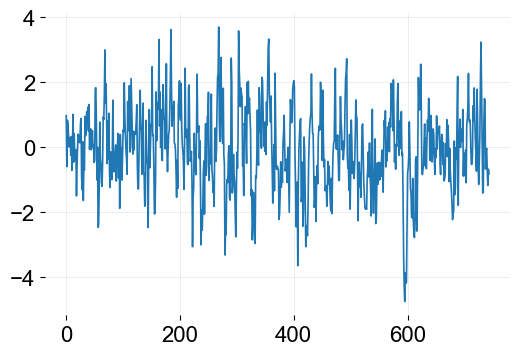

In [4]:
# make the data
n = 744 # hourly for 1 month 

eta = np.random.normal(0, 1.0, n)

rho = [0.60, -0.15]
y = eta.copy()
for i in range(2, n):
    y[i] = rho[0]*y[i-1] + rho[1]*y[i-24] +eta[i]
     
plt.plot(y);

In [5]:
def daterange(start_date, end_date):
    delta = timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta
        
hours = [datetime(2013, 1, 1, 14, 00)]        

start_date = datetime(2021, 1, 1, 00, 00)
end_date = datetime(2022, 1, 1, 00, 00)
i = 0
for single_date in daterange(start_date, end_date):
    hours[i] = hours.append(single_date.strftime("%Y-%m-%d %H:%M"))       
    i += i
    
hours = hours[1:(n+1)]
hours = [dt.datetime.strptime(hour, "%Y-%m-%d %H:%M") for hour in hours]

In [6]:
df = pd.DataFrame()
df['hours'] = hours
df['y'] = y

In [7]:
df_train = df[0:372]
df_test = df[372:n]

## Fitting Models AR(1, 24)  & Prediction

### from Orbit

In [8]:
# orbit model and prediction 
mod = ARMA(
        level_first=0,
        estimator='stan-mcmc',
        date_col='hours',
        response_col='y',
#         ma_lags = [1],
        ar_lags = [1, 24],
    num_warmup=10000,
    num_sample=50000,
)
mod.fit(df_train)
# orbit automatically match dates for prediction based on date_col
pred = mod.predict(df_test)

INFO:orbit:Sampling(PyStan) with chains:4, cores:8, temperature:1.0, warmups(per chain):2500 and samples(per chain):12500.


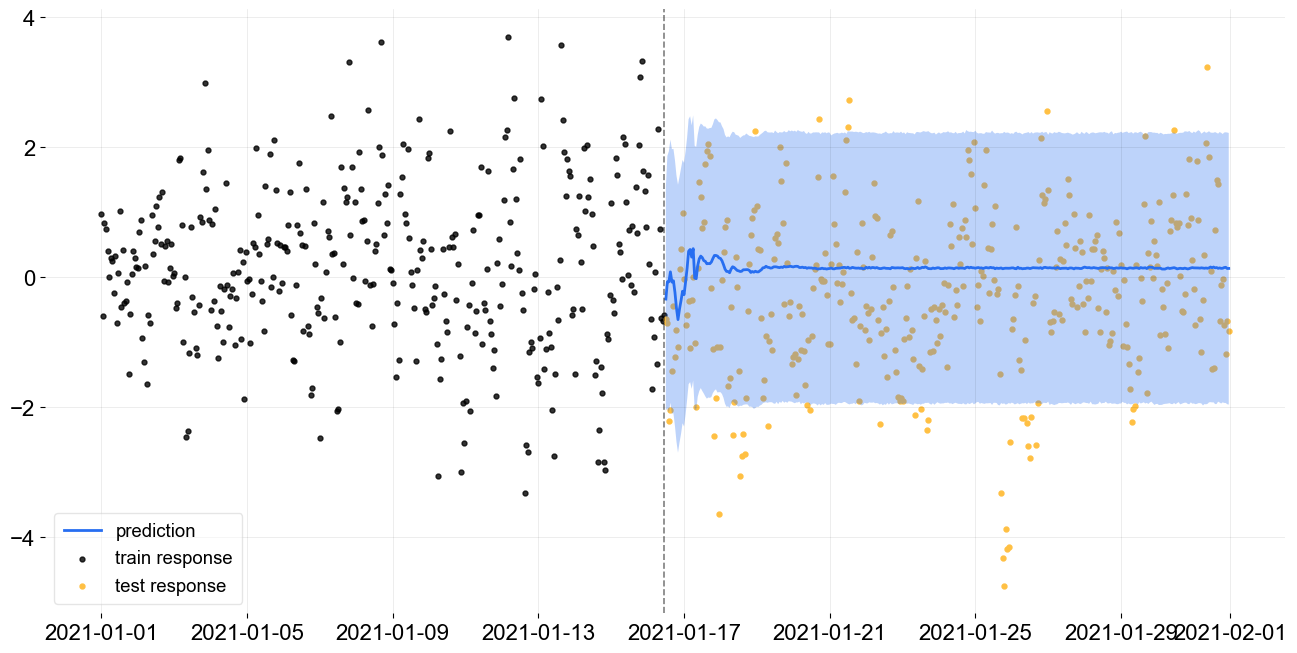

In [9]:
plot_predicted_data(
    training_actual_df=df_train, 
    predicted_df=pred,  
    date_col='hours', 
    actual_col='y',
    test_actual_df=df_test,
);

### from statsmodels

In [10]:
# stats model and prediction 
y = pd.Series(df_train['y'])
arma_mod = ARIMA(y, order=(1, 0, 0), seasonal_order= (1, 0, 0, 24))
arma_res = arma_mod.fit()
forecast = arma_res.get_forecast(372)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.10)
pred['prediction_5_statsmodel'] = yhat_conf_int['lower y'].values
pred['prediction_statsmodel'] = yhat.values
pred['prediction_95_statsmodel'] = yhat_conf_int['upper y'].values

## Results Comparison Orbit vs. Statsmodel

### Predictions

In [11]:
pred = pred.rename(columns={
    'prediction': 'prediction_orbit',
    'prediction_5': 'prediction_5_orbit',
    'prediction_95': 'prediction_95_orbit',
})

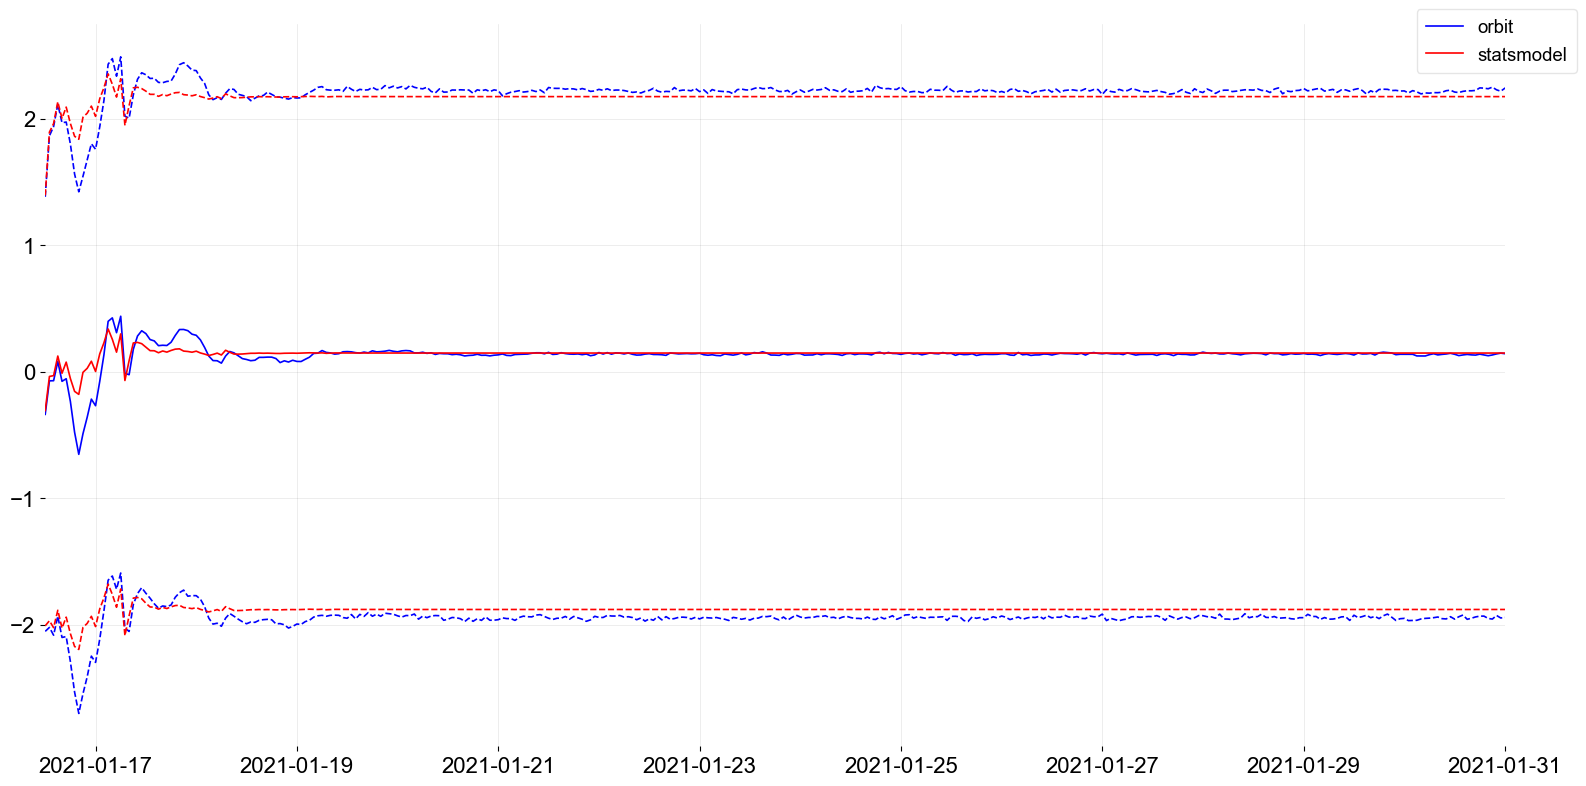

In [12]:
# plot the two predictions 

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.set_xlim([dt.datetime(2021, 1, 16, 12,0,0), dt.datetime(2021, 1, 31, 0,0,0)])
ax.plot(pred['hours'].values, pred['prediction_orbit'].values, label='orbit', color = "blue")
ax.plot(pred['hours'].values, pred['prediction_5_orbit'].values,  color = "blue", linestyle='--')
ax.plot(pred['hours'].values, pred['prediction_95_orbit'].values, color = "blue", linestyle='--')

ax.plot(pred['hours'].values, pred['prediction_statsmodel'].values, label='statsmodel', color = "red")
ax.plot(pred['hours'].values, pred['prediction_95_statsmodel'].values, color = "red", linestyle='--')
ax.plot(pred['hours'].values, pred['prediction_5_statsmodel'].values, color = "red", linestyle='--')

fig.legend(bbox_to_anchor=(1, 1), loc='upper right', ncol=1)
fig.tight_layout()

### Parameters

In [13]:
# get posteriors from orbit and statsmodel 
labels = ['const', 'ar1', 'ar24', 'obs_sigma']
p = (50, 2.5, 97.5, 25, 75)

# orbit 
posterior_samples = mod.get_posterior_samples()
orbit_result = np.stack([
    np.percentile(posterior_samples['mu'], p), 
    np.percentile(posterior_samples['rho'][:,0], p),
    np.percentile(posterior_samples['rho'][:,1], p),
    np.percentile(posterior_samples['obs_sigma'], p),
]).transpose()

# statsmodel
t1 = arma_res.summary().tables[1]
sm_mid = list()
sm_lower = list()
sm_upper = list()
for x in t1.data[1:]:
    sm_mid.append(float(x[1]))
    sm_lower.append(float(x[5]))
    sm_upper.append(float(x[6]))
    
sm_result =np.stack([np.array(sm_mid), np.array(sm_lower), np.array(sm_upper), arma_res.conf_int(.25)[0], arma_res.conf_int(.25)[1]])

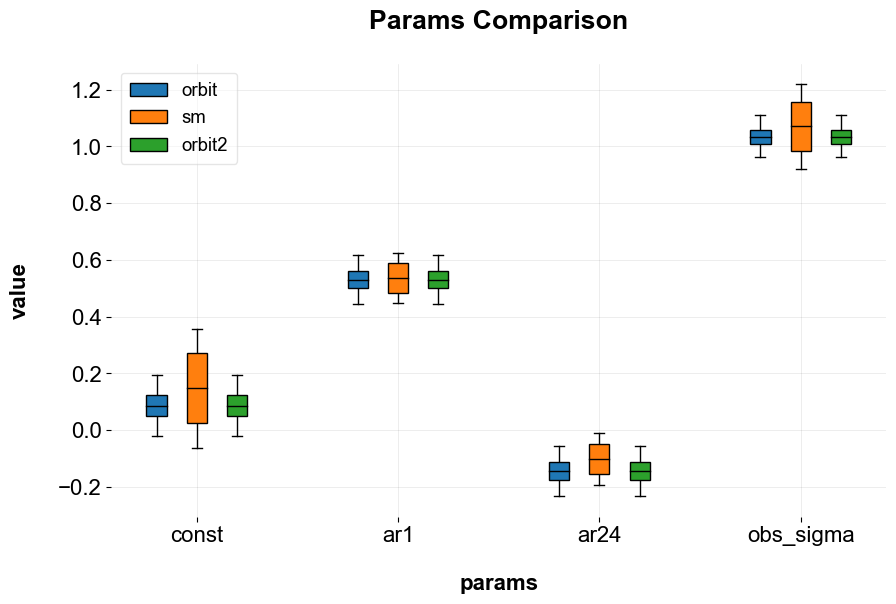

In [14]:
params_comparison_boxplot(
    model_list = ['orbit', 'sm', 'orbit2'], 
    data_list = [orbit_result, sm_result, orbit_result], 
    label_list = labels, 
    color_list = sns.color_palette(), 
    showfliers = True
)

### Print Summary

In [14]:
# orbit 
A = mod.get_posterior_samples()
print('const'+' '+ str(np.percentile(A['mu'], p) ))
print('ar_1'+' '+str(np.percentile(A['rho'][:,0], p)))
print('ar_24'+' '+str(np.percentile(A['rho'][:,1], p)))
print('sigma'+' '+str(np.percentile(A['obs_sigma'], p)))

const [-0.028824   -0.13008672  0.0725341 ]
ar_1 [0.51869965 0.43062219 0.60714941]
ar_24 [-0.07958767 -0.17285308  0.01410258]
sigma [0.9927037  0.92485182 1.06768479]


In [15]:
# statsmodel
arma_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                                y   No. Observations:                  372
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood                -522.851
Date:                          Tue, 15 Feb 2022   AIC                           1053.703
Time:                                  15:52:56   BIC                           1069.378
Sample:                                       0   HQIC                          1059.928
                                          - 372                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0516      0.100     -0.517      0.605      -0.247       0.144
ar.L1          0.5218      0.042     12.362      0.000       0.439       0.605
ar.S.L24      -0.0860      0.054     -1.597      0.110      -0.191       0.020
sigma2         0.9722      0.069     14.180      0.000       0.838       1.107
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.53   Prob(JB):                         0.72
Heteroskedasticity (H):               1.57   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""